## 1. Elaboração do problema

O principal objetivo desse projeto é melhor entender o comportamento de clientes que fazem uso de um cartão de crédito e que apresentam ou não casos de inadimplência. Entender esse comportamento pode ajudar um banco, por exemplo, a identificar melhor os clientes que possuem risco de não efetuarem o pagamento da fatura do seu cartão de crédito.  

O estudo encontrado neste [link](https://www.sciencedirect.com/science/article/abs/pii/S0957417407006719) diz que, os banco emissores de cartão de crédito estavam enfrentando uma crise de caixa e dívidas de cartão de crédito e a inandimplência atingiu um valor alto no terceiro trimestre de 2006. Em busca de aumentar sua participação no mercados, os bancos acabaram por emitir cartões de crédito em excesso para diversos clientes que não são, de certa forma, "qualificados". 
Isso causou um consumo exacerbado desses cartões ao ponto de acumularem dívidas altissimas e consequentemente, não pagando-as.

Utilizando técnicas de _Machine Learning_ é possível encontrar um modelo que melhor faz a previsão de um cliente que pode ou não se tornar inadimplente, baseado nos dados históricos que se tem a respeito do mesmo. Atualmente é uma prática comum entre os bancos, desenvolverem ferramentas para melhor entender cada cliente. Compreender o padrão de consumo, renda, etc, ajuda a empresa a limitar ou até fornecer certo bônus para o mesmo, além de identificar previamente um possível inadimplente que está solicitando um determinado valor de crédito.

O _dataset_ utilizado para esse projeto está disponível no [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#) e diz respeito a clientes de um banco em Taiwan, onde estão disponíveis diversas informações sobre eles, como o limite do cartão de crédito, quando as faturas dos últimos 6 meses foram pagas, quais foram essas faturas, de quanto foram os últimos pagamentos entre outros.

## 2. Importando as biblioteca e carregandos os dados

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

mpl.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [12]:
df = pd.read_excel('default of credit card clients.xls', header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 3. Contato inicial e limpeza dos dados

O dataset que estamos trabalhando, empregou uma variável binária, o pagamento inadimplente, como sendo **1** para **SIM** e **0** para **NÃO**
- **ID**: Número de identificação atribuído a cada cliente
- **LIMIT_BAL**: Limite de Crédito
- **SEX**: Gênero
- **EDUCATION**: Nível de educação
- **MARRIAGE**: Estado civil
- **AGE**: Idade
- **PAY_**: Quando as últimas 6 contas foram pagas
- **BLL_AMT**: Quais foram as últimas 6 contas
- **PAY_AMT**: Quanto foram os úlitmos pagamentos
- **default payment next month**

De forma a facilitar o entendimento da nossa variável que iremos realizar a predição, vamos renomea-lá de **default payment next month** para apenas **DEFAULT**.

In [13]:
df.rename({'default payment next month':'DEFAULT'}, axis = 'columns',
         inplace=True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Neste problema não iremos fazer uso da coluna (_feature_) **ID**, por esse motivo vamos descartá-la.

In [14]:
df.drop('ID', axis=1, inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Um breve resumo das estatísticas descritivas do nosso conjunto de dados está mostrado na célula logo abaixo.

In [16]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Podemos tirar algumas características dos nossos dados olhando para a tabela acima, como por exemplo:
- Dos clientes presentes no dataset, o mais novo apresenta a idade de 21 anos e o mais velho apresenta a idade de 79 anos.
- A média do limite do cartão de crédito dos clientes é de 167.484,32 dólares.

Vamos entender melhor o significado de cada uma das _features_ do dataset e quais valores (ou categorias) as mesmas podem tomar.

- **LIMIT_BAL**, a quantidade de crédito disponível **Inteiro**
- **SEX**: **Categórica**
    - 1 = Masculino
    - 2 = Feminino
- **EDUCATION**: **Categórica**
    - 1 = Pós-graduação
    - 2 = Universidade
    - 3 = Ensino médio
    - 4 = Outros
- **MARRIAGE**: **Categórica**
    - 1 = Casado
    - 2 = Solteiro
    - 3 = Outros
- **AGE**: **Inteiro**
- **PAY_**: quando as últimas 6 contas foram pagas **Categórica**
    - -1 = Paga no tempo certo
    - 1 = Pagamento atrasado em 1 mês
    - 2 = Pagamento atrasado em 2 meses
    - ...
    - 7 = Pagamento atrasado em 7 meses
    - 8 = Pagamento atrasado em 8 meses ou mais
- **BLL_AMT**: quais foram as últimas 6 contas **Inteiro**
- **PAY_AMT**: de quanto foram os últimos pagamentos **Inteiro**
- **DEFAULT**
    - 0 = Não Inadimplente
    - 1 = Inadimplente

In [35]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT'],
      dtype='object')

In [21]:
colunas = list(df.columns)
for col in colunas:
    print("{} : ".format(col))
    print(df[col].unique())

LIMIT_BAL : 
[  20000  120000   90000   50000  500000  100000  140000  200000  260000
  630000   70000  250000  320000  360000  180000  130000  450000   60000
  230000  160000  280000   10000   40000  210000  150000  380000  310000
  400000   80000  290000  340000  300000   30000  240000  470000  480000
  350000  330000  110000  420000  170000  370000  270000  220000  190000
  510000  460000  440000  410000  490000  390000  580000  600000  620000
  610000  700000  670000  680000  430000  550000  540000 1000000  530000
  710000  560000  520000  750000  640000   16000  570000  590000  660000
  720000  327680  740000  800000  760000  690000  650000  780000  730000]
SEX : 
[2 1]
EDUCATION : 
[2 1 3 4]
MARRIAGE : 
[1 2 3 0]
AGE : 
[24 26 34 37 57 29 23 28 35 51 41 30 49 39 40 27 47 33 32 54 58 22 25 31
 46 42 43 45 56 44 53 38 63 36 52 48 55 60 50 75 61 73 59 21 67 66 62 70
 72 64 65 71 69 68 79 74]
PAY_0 : 
[ 2 -1  0 -2  1  3  4  8  7  5  6]
PAY_2 : 
[ 2  0 -1 -2  3  5  7  4  1  6  8]
PAY_

Pela célula acima, vemos que as features `EDUCATION` e `MARRIAGE` não estão disponíveis da forma como esperamos. Por esse motivo, vamos ajusta-las deixando-as no formato que foi apresentado anteriormente

In [23]:
df['EDUCATION'].replace(to_replace=[0,5,6], value = 4, inplace=True)
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [24]:
df['MARRIAGE'].replace(to_replace=0, value = 3, inplace=True)
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

Antes de partirmos para a análise exploratória, vamos verificar se o nosso dataset possui valores faltantes em suas instâncias.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

In [37]:
df.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
DEFAULT      0
dtype: int64

Não existem valores faltantes nesse dataset, dessa forma, podemos seguir com a análise exploratória dos dados.

## 4. Análise Exploratória dos Dados (EDA)

O objetivo principal deste projeto é desenvolver um modelo de _Machine Learning_ que seja capaz de identificar se um determinado cliente pode a pagar ou não, a sua fatura do cartão de crédito. Em outras palavras, identificar um potencial cliente inadimplente. Nesse conjunto de dados que estamos trabalhando, precisamos inicialmente entender como está distribuida a porcentagem de clientes que realizaram o pagamento de suas faturas ou não. Esso é o nosso objetivo, (_target_).

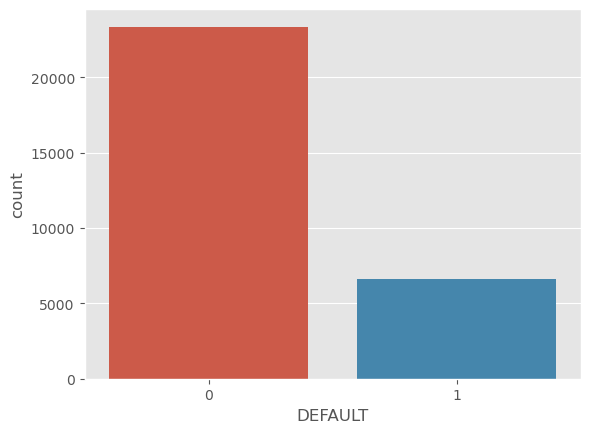

In [39]:
sns.countplot(x=df['DEFAULT']);

In [42]:
sim = df['DEFAULT'] == 1
nao = df['DEFAULT'] == 0
total = len(df['DEFAULT'])
proporcao_sim = (sim.sum()/total)*100
proporcao_nao = (nao.sum()/total)*100
print(f"Sim: {proporcao_sim:.2f} %")
print(f"Não: {proporcao_nao:.2f} %")

Sim: 22.12 %
Não: 77.88 %


Dentre os clientes do dataset, **22,12%** deles não realizaram o pagamento da sua fatura do cartão de crédito. Então baseado nas caracteristicas desses clientes que iremos desenvolver um modelo que consiga no dizer se um futuro cliente que está solicitando um cartão de crédito é um potencial inadimplente ou não. 

Posteriormente será analisado a necessidade ou não de realizar um balanceamento das duas classes que estão mostradas logo acima.

Vamos avaliar a distribuição das nossas principais variáveis contínuas `LIMIT_BAL` e `AGE`.

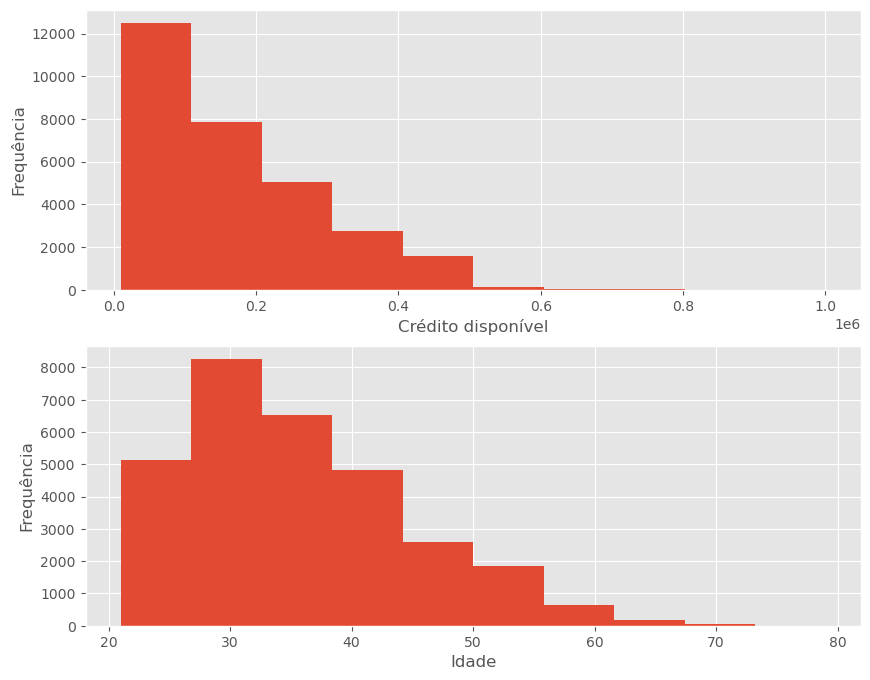

In [49]:
fig, axes = plt.subplots(nrows=2, figsize=(10,8))
plt.sca(axes[0])
df['LIMIT_BAL'].plot(kind='hist')
plt.xlabel('Crédito disponível')
plt.ylabel('Frequência')
plt.sca(axes[1])
df['AGE'].plot(kind='hist')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show();

Vamos avaliar a distribuição das variáveis categóricas `EDUCATION` e `MARRIAGE`.

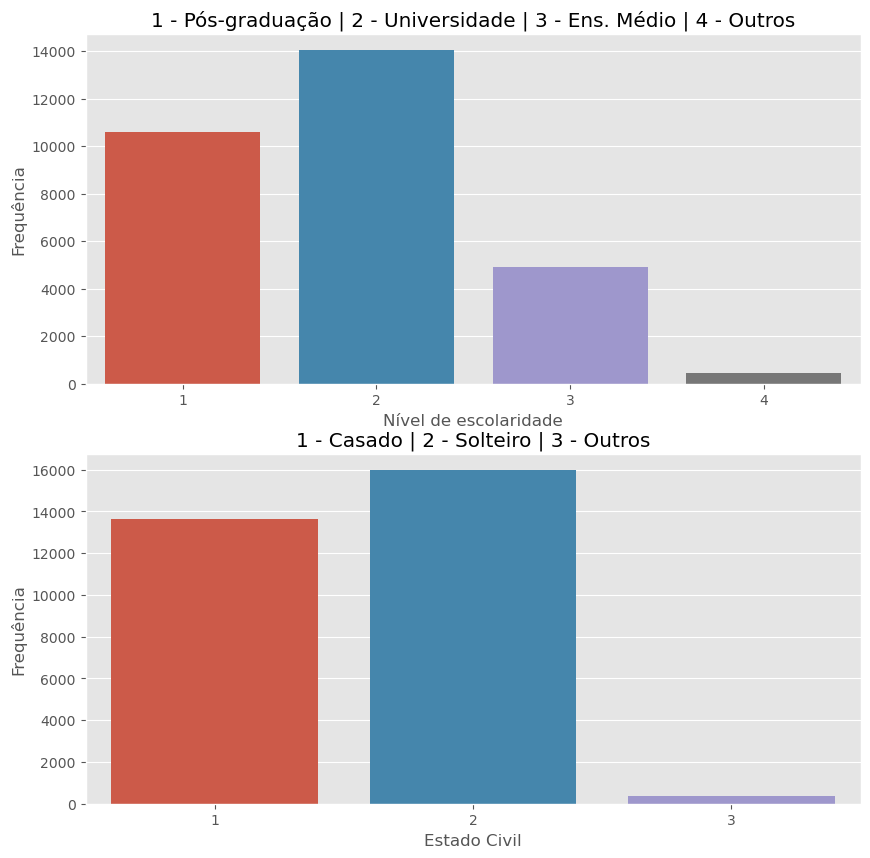

In [67]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))
plt.sca(axes[0])
sns.countplot(x=df['EDUCATION'])
plt.xlabel('Nível de escolaridade')
plt.ylabel('Frequência')
plt.title('1 - Pós-graduação | 2 - Universidade | 3 - Ens. Médio | 4 - Outros')
plt.sca(axes[1])
sns.countplot(x=df['MARRIAGE'])
plt.xlabel('Estado Civil')
plt.ylabel('Frequência')
plt.title('1 - Casado | 2 - Solteiro | 3 - Outros')
plt.show();

No que diz respeito as variáveis de pagamento (`PAY_`) que foram feitas nos últimos 6 meses, temos a seguinte distribuição abaixo:

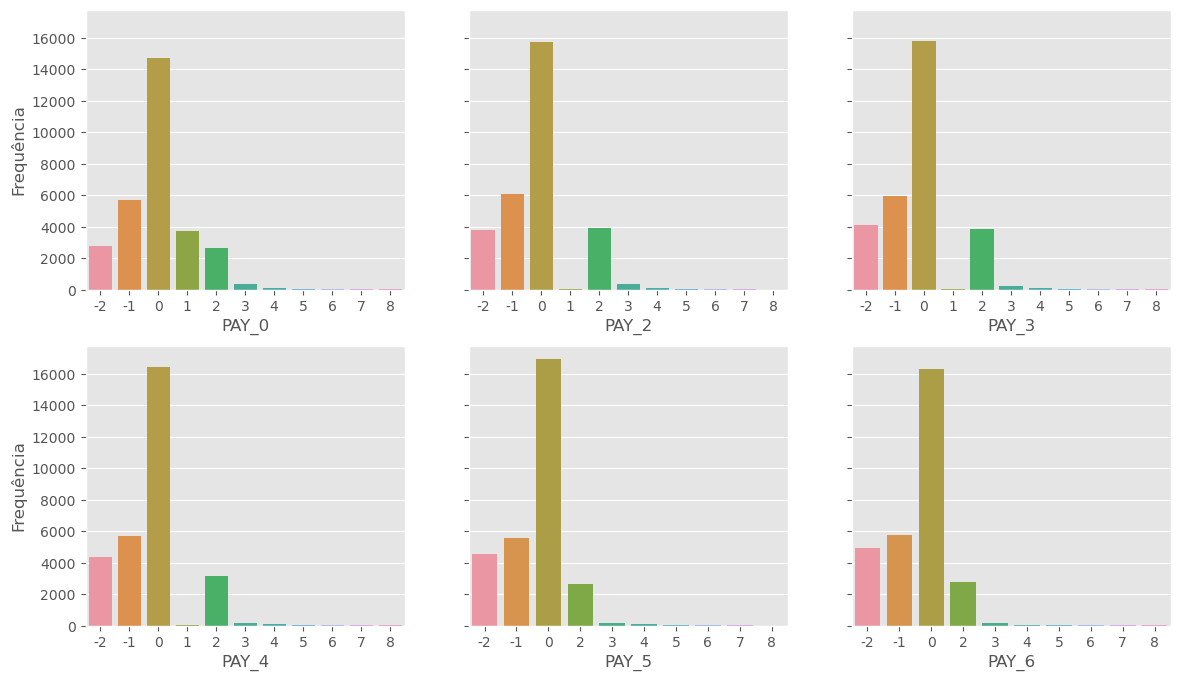

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8),
                         sharey=True)
pay = []
for i in range(5,11):
    pay.append(df.columns[i])
    
for i, n in enumerate(pay):
    plt.sca(axes[i//3, i %3])
    sns.countplot(x=df[n])
    plt.xlabel(n)
    plt.ylabel("Frequência")
    if (i == 1) or (i == 2) or (i == 4) or (i == 5):
        plt.ylabel("")

Já para as variáveis que dizem respeito ao valor do pagamento (`BILL_AMT`) dessas contas dos últimos 6 meses, temos a seguinte distribuição: 

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8),
                         sharey=True)
bill_amt = []
for i in range(11,17):
    bill_amt.append(df.columns[i])
    
for i, n in enumerate(bill_amt):
    plt.sca(axes[i//3, i %3])
    sns.countplot(x=df[n])
    plt.xlabel(n)
    plt.ylabel("Frequência")
    if (i == 1) or (i == 2) or (i == 4) or (i == 5):
        plt.ylabel("")

### 4.1 Correlações

Agora iremos avaliar possíveis correlações que as _features_ do dataset possuem entre si. Para isso, é comum utilizar a função `heatmap` do _Seaborn_, como ilustra a célula abaixo:

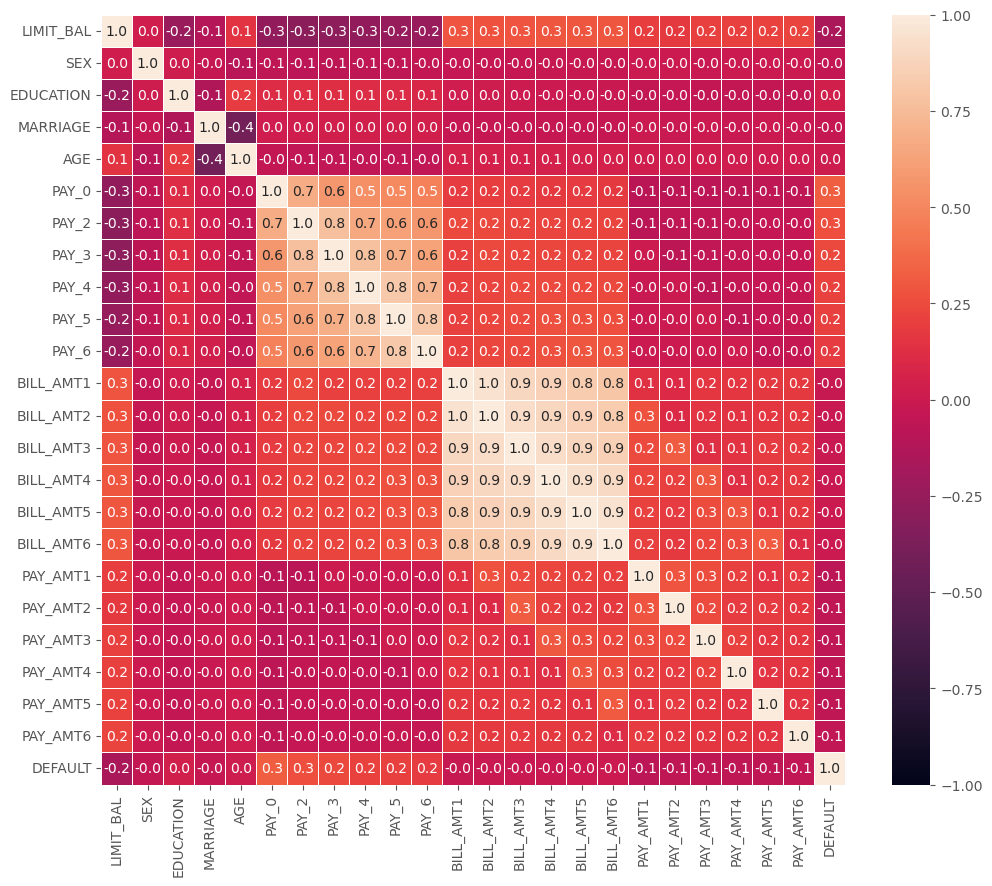

In [70]:
plt.figure(figsize=(12,10))
correlacao = df.corr()
sns.heatmap(correlacao, vmin = -1, vmax = 1,
           annot = True,
           fmt=".1f",
           linewidths=.4);

De acordo com a escala a direita, os tons mais claros dizem respeito a fortes correlações positivas, ou seja, conforme a variável "x" aumenta, a outra que está sendo avaliada a correlação, "y" também aumenta. Enquanto que para tons mais escuros dizem respeito a fortes correlações negativas, isto é, conforme a variável "x" aumenta, a variável "y" diminui.

É possível identificar por esse `heatmap` que as _features_ `PAY_` dos últimos 6 meses possuem uma forte correlação positiva. Da mesma forma que as _features_ `BILL_AMT`, que dizem a quais foram essas contas dos últimos 6 meses.

Vamos investigar mais afundo essa correlação avaliando o `pairplot` dessas _features_.

In [71]:
pagamento = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
montante_pag = ['BILL_AMT1','BILL_AMT2','BILL_AMT3',
                'BILL_AMT4','BILL_AMT5','BILL_AMT6']
valor_pago = ['PAY_AMT1','PAY_AMT2','PAY_AMT3',
              'PAY_AMT4','PAY_AMT5','PAY_AMT6']

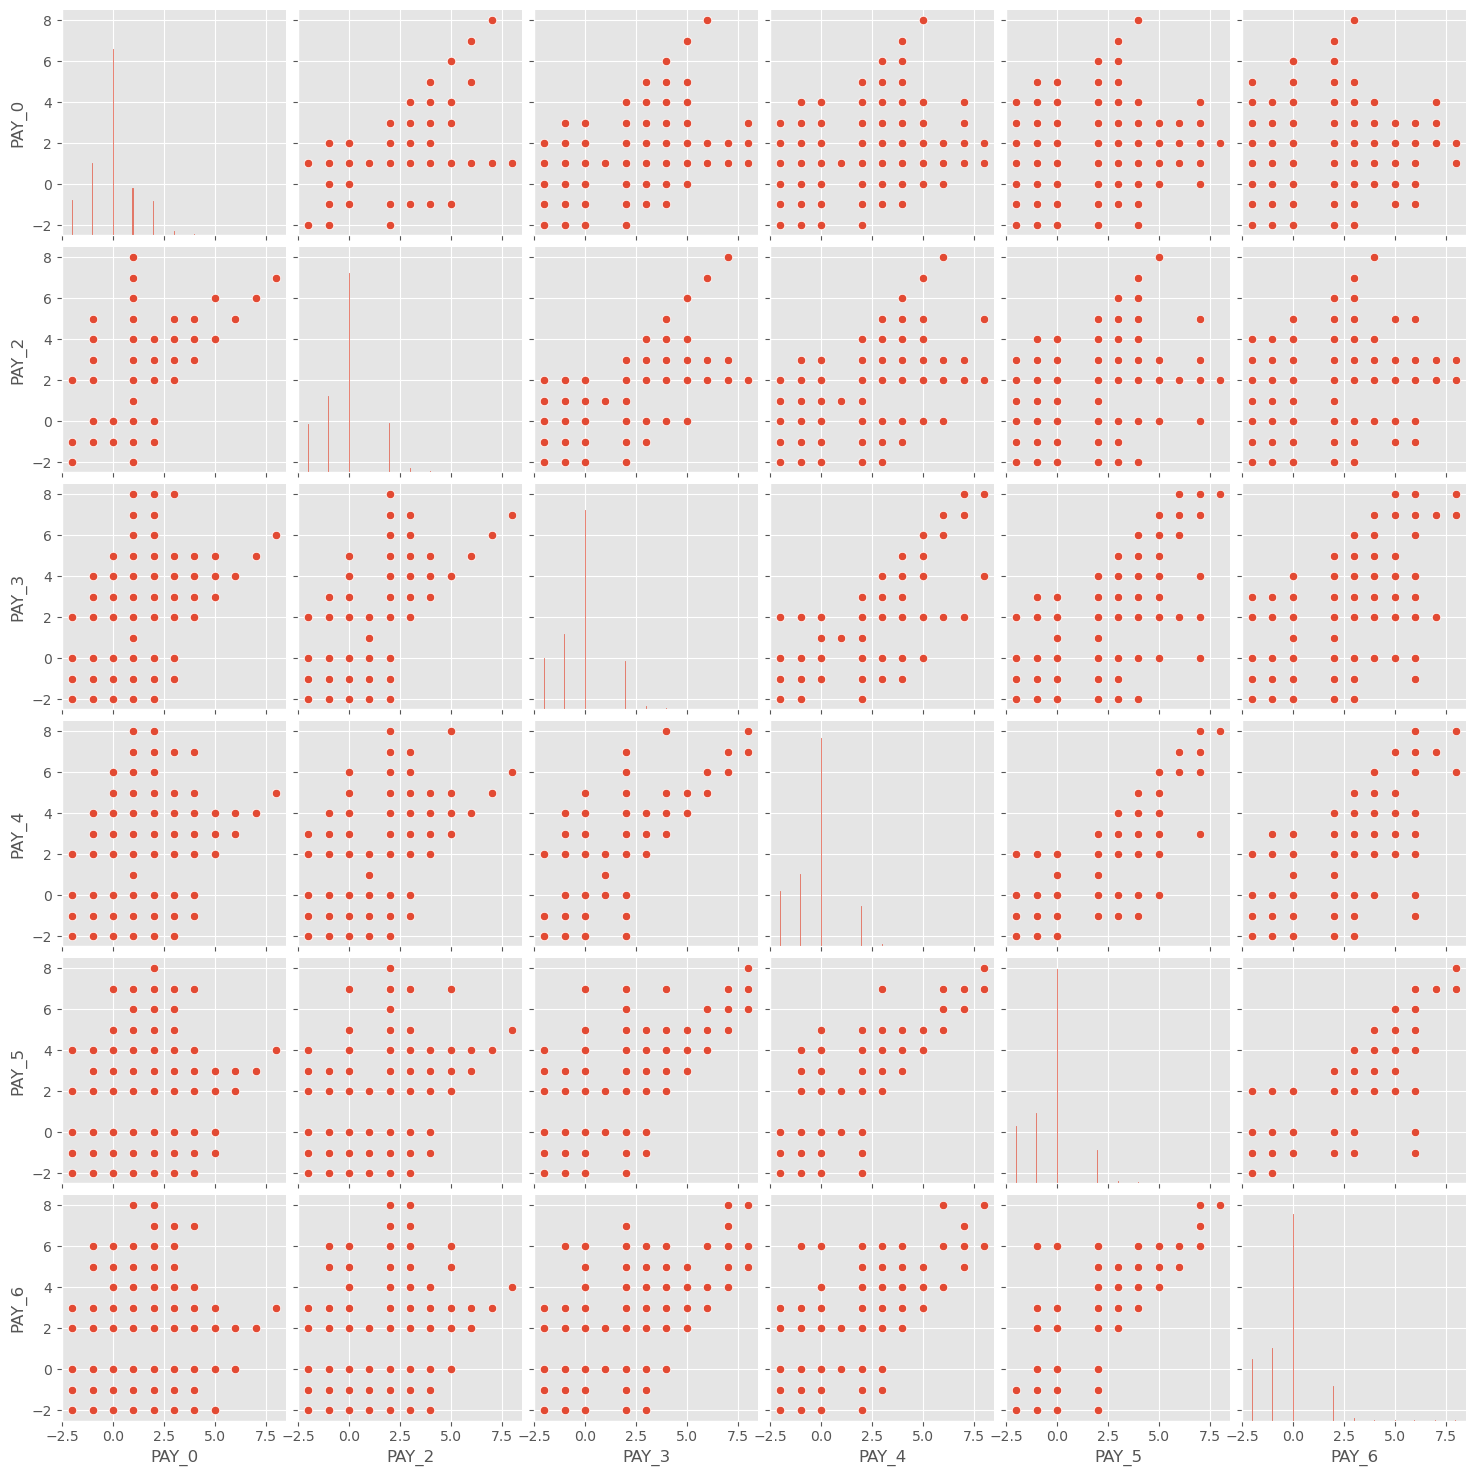

In [72]:
sns.pairplot(df[pagamento], vars = pagamento)
plt.show()

Em algumas situações é possível identificar uma correlação entre quando as últimas 6 faturas foram pagas, como por exemplo entre `PAY_0` e `PAY_2`. Em outras não fica tão fácil identificar essa correlação, como por exemplo entre `PAY_0` e `PAY_5`.

Essa mesma avaliação será feita para a feature `BILL_AMT` conforme `pairplot` abaixo:

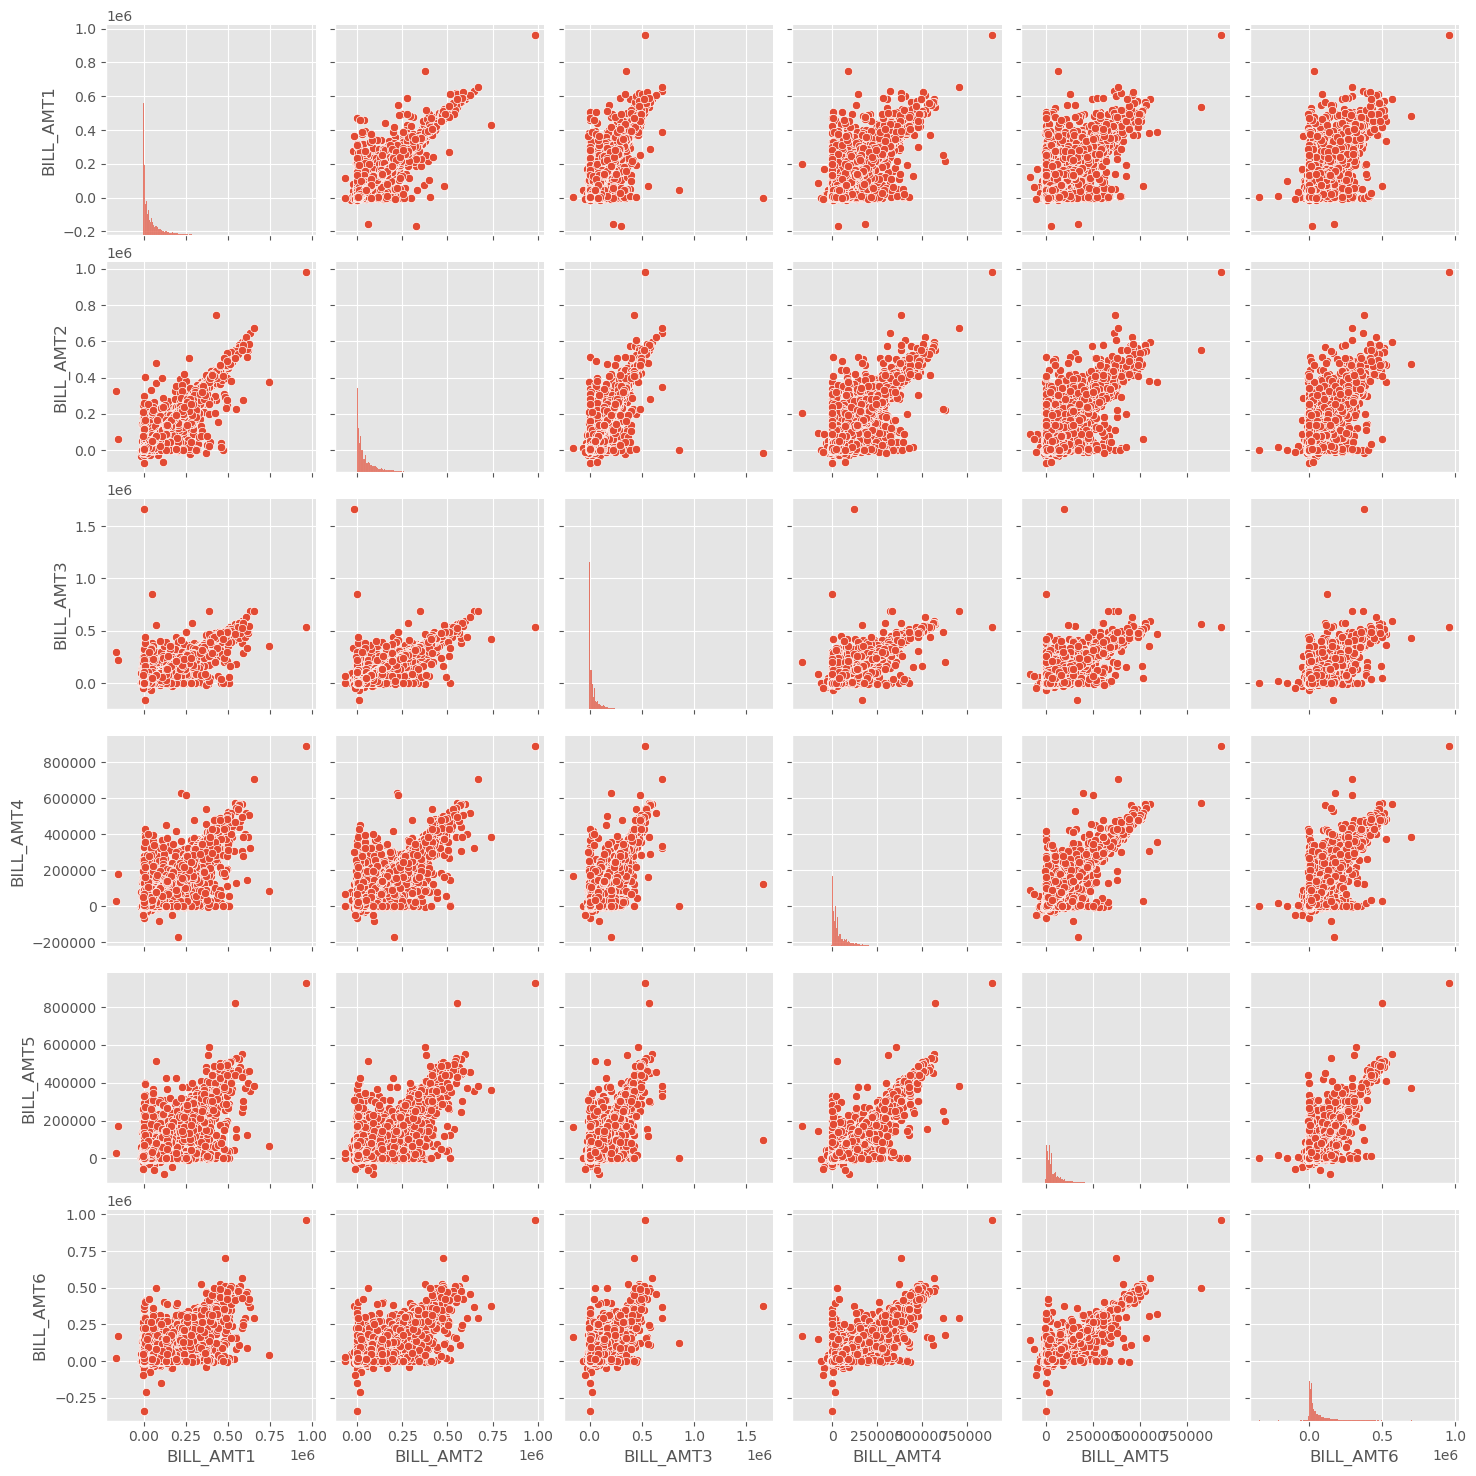

In [73]:
sns.pairplot(df[montante_pag], vars = montante_pag)
plt.show()

Nesse cenário, a correlação entre quais foras as 6 últimas faturas é muito mais evidente do que na célula anterior. Podemos observar uma forte correlação entre `BILL_AMT2` e `BILL_AMT1`, da mesma forma entre `BILL_AMT4` e `BILL_AMT5`.

## 5. Pré-processamento dos dados

Como foi visto no início da análise exploratória, nesse dataset temos uma distribuição de 22% dos clientes que são identificados como inadimplentes e 78% dos mesmos como não-inadimplentes. Vamos realizar aqui uma técnica de _Undersampling_ da classe majoritária chamada de `RandomUnderSampler`. Ela coniste em aleatóriamente remover instâncias dessa classe majoritária de forma a balancear o dataset. A sua implementação pode ser vista na célula abaixo e para termos uma razão de 50:50, basta apenas difinirmos o parâmetro `sampling_strategy` como auto na construção do _undersampler_.

### 5.1 _RandomUnderSampler_

In [75]:
X = df.drop('DEFAULT', axis=1).copy()
y = df['DEFAULT'].copy()

rus = RandomUnderSampler(sampling_strategy='auto',
                        random_state=0)
X_resampled, y_resampled = rus.fit_resample(X,y)

In [76]:
X_resampled.shape, y_resampled.shape

((13272, 23), (13272,))

Aqui iremos apenas realizar a divisão do dataset em subconjunto de treinamento e teste. É fundamental que essa divisão seja realizada antes da etapa de pré-processamento para evitar com que haja "vazamento de dados de treino para o conjunto de teste. Esse fenômeno é comumente chamado de **data leakage** e caso o mesmo ocorra, pode levar o modelo a cair em **overfitting** durante sua etapa de avaliação.

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,
                                                   y_resampled,
                                                   random_state=42)

In [78]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9954, 23), (3318, 23), (9954,), (3318,))

### 5.2 Combinações de diferentes features engineering

In [79]:
numericas = []
categoricas = []

for col in list(df.columns):
    if df[col].nunique() > 11:
        numericas.append(col)
    else:
        categoricas.append(col)
del(categoricas[-1])

De forma a avaliar qual tipo de pré-processamento se encaixa melhor para os modelos que serão implementados, aqui é feita a construção de diversas `Pipelines` para combinar diferentes formas de _encoding_ e _scaling_ dos dados. 
Os _transformers_ avaliados aqui são: `OneHotEncoder()` para o _encoding_ das _features_ que são tratadas como categóricas, enquanto que são construido `MinMaxScaler()`, `StandardScaler()` e `RobustScaler()` para realizar o _scaling_ entre os dados. O `MinMaxScaler()` realiza o _scaling_ baseando em um valor máximo e mínimo que os dados podem assumirem, o `StandardScaler()` faz isso removendo a média dos dados e deixando-os com variância unitária e o `RobustScaler()` remove a média e escalona os dados de acordo com os InterQuartis, deixando assim, mais robusto a _outliers_.

In [80]:
cat_transformer_OH = Pipeline(steps = [
    ('one hot enc', OneHotEncoder(categories='auto', handle_unknown = 'ignore'))
])

num_transformer_MM = Pipeline(steps = [
    ('min max scaler', MinMaxScaler())
])

num_transformer_SS = Pipeline(steps = [
    ('standard scaler', StandardScaler())
])

num_transformer_RS = Pipeline(steps = [
    ('robust scaler', RobustScaler())
])

# Preprocessing 1
# One Hot Encoder + Min Max Scaler
preprocessing_1 = ColumnTransformer(transformers = [
    ('cat', cat_transformer_OH, categoricas),
    ('num', num_transformer_MM, numericas)
])

# Preprocessing 2
# One Hot Encoder + StandardScaler
preprocessing_2 = ColumnTransformer(transformers = [
    ('cat', cat_transformer_OH, categoricas),
    ('num', num_transformer_SS, numericas)
])

# Preprocessing 3
# One Hot Encoder + Robust Scaler
preprocessing_3 = ColumnTransformer(transformers = [
    ('cat', cat_transformer_OH, categoricas),
    ('num', num_transformer_RS, numericas)
])

# Preprocessing 4
# One Hot Encoder sem escalonamento
preprocessing_4 = ColumnTransformer(transformers = [
    ('cat', cat_transformer_OH, categoricas)
])

preprocessing_list = [preprocessing_1, preprocessing_2, 
                     preprocessing_3, preprocessing_4]

## 6. Aplicando diversos modelos

Nessa etapa vamos avaliar diferentes modelos tradicionais de _Machine Learning_ para avaliarmos e escolhermos qual deles será o modelo final que irá ser implementado. Os algoritmos que serão avaliados são: `LogisticRegression()`, `RandomForestClassifier()`, `AdaBoostClassifier()`, `GradienteBoostingClassifier()` e `XGBClassifier()`. Uma breve descrição sobre esses algoritmos é feita logo abaixo: 

- **Logistic Regression**: é um algoritmo de machine learning usado para modelar a probabilidade de um evento ocorrer. É frequentemente usado em problemas de classificação binária, onde o objetivo é prever se um exemplo pertence a uma das duas classes possíveis. A Regressão Logística modela a probabilidade de um exemplo pertencer a uma das classes usando uma função logística, que mapeia uma entrada contínua para uma saída no intervalo [0, 1]. Durante o treinamento, o modelo ajusta os parâmetros de tal forma que a função logística se ajuste aos dados de treinamento de maneira ideal, maximizando a probabilidade de obter as classes corretas. Ele pode lidar com dados não lineares através de transformações de características, como a criação de novas variáveis a partir de combinações lineares das variáveis originais. Além disso, a Regressão Logística é menos suscetível a overfitting do que outros algoritmos de machine learning.
- **Random Forest**: é um algoritmo de machine learning que pertence à família de métodos de "ensemble learning". Ela é uma extensão da Decision Tree, que combina várias Decisions Tree individuais para criar um modelo mais robusto e geralmente mais preciso. Um conjunto aleatório de subconjuntos de dados é extraído do conjunto de dados original para treinar várias Decisions Tree. Cada Tree é treinada de forma independente, usando uma amostra aleatória do conjunto de dados original, e toma decisões com base em um conjunto aleatório features. A Random Forest tem várias vantagens, como a capacidade de lidar com dados desbalanceados, a capacidade de lidar com um grande número de recursos e a capacidade de detectar interações não lineares entre features. Ela também é menos suscetível a overfitting do que uma única Decision Tree, pois cada Tree é treinada em uma amostra diferente dos dados.
- **AdaBoost**: o AdaBoost (Adaptive Boosting) é um algoritmo ensemble de aprendizado de máquina utilizado para classificação. Ele combina várias instâncias de um classificador fraco para formar um classificador forte. O AdaBoost é um algoritmo iterativo que ajusta os pesos dos exemplos de treinamento com base no desempenho do classificador em cada iteração. O processo é repetido por um número pré-definido de iterações ou até que um critério de parada seja atingido. Uma das principais vantagens do AdaBoost é sua capacidade de lidar com dados desbalanceados, onde uma classe é muito mais frequente do que a outra. Ele também é robusto em relação a overfitting. No entanto, o AdaBoost pode ser sensível a outliers e ruídos nos dados.
- **Gradient Boost**: é um algoritmo ensemble de aprendizado de máquina usado para problemas de classificação e regressão. Ele combina várias árvores de decisão para criar um modelo preditivo mais robusto e preciso. O Gradient Boosting é baseado no conceito de gradient descent, onde os erros são minimizados iterativamente, ajustando os pesos dos exemplos de treinamento. O Gradient Boosting é conhecido por sua capacidade de lidar com dados desbalanceados, assim como o AdaBoost. Ele também pode capturar relações não lineares nos dados e fornecer boas previsões. No entanto, o Gradient Boosting é mais propenso a overfitting se os parâmetros não forem adequadamente ajustados.
- **XGBoost**: é um algoritmo ensemble de aprendizado de máquina que é utilizado para resolver problemas de classificação. Ele combina várias árvores de decisão fracas para construir um modelo mais forte e preciso. O Gradient Boosting funciona de forma iterativa, onde cada nova árvore é ajustada aos erros residuais dos modelos anteriores. O Gradient Boosting é eficaz na construção de modelos complexos que podem capturar relações não lineares entre as variáveis. Ele pode lidar com dados desbalanceados e é menos propenso a overfitting em comparação com algoritmos como o Decision Tree. No entanto, é importante ajustar adequadamente os hiperparâmetros do Gradient Boosting para obter os melhores resultados.

In [82]:
modelos = [LogisticRegression(),
          RandomForestClassifier(),
          AdaBoostClassifier(),
          GradientBoostingClassifier(),
          xgb.XGBClassifier(objective='binary:logistic', seed=42)]

modelos_nomes = ['LogisticRegression',
                'RandomForest',
                'AdaBoost',
                'GradientBoosting',
                'XGBoost']

for modelo in modelos:
    i = 1
    print(f"---- Métricas de desempenho - {modelo} ----")
    for preprocessing in preprocessing_list:
        pipe = Pipeline(steps = [('preprocessing', preprocessing),
                                ('modelos', modelo)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        print(f"-- preprocessing {i} --")
        print(f"- Acurácia: {accuracy_score(y_test, y_pred):.2f}")
        print(f"- Precisão: {precision_score(y_test, y_pred):.2f}")
        print(f"- Recall: {recall_score(y_test, y_pred):.2f}")
        print(f"- F1 score: {f1_score(y_test, y_pred):.2f}")
        print(f"- ROC-AUC: {roc_auc_score(y_test, y_pred):.2f}")
        i += 1

---- Métricas de desempenho - LogisticRegression() ----
-- preprocessing 1 --
- Acurácia: 0.71
- Precisão: 0.78
- Recall: 0.58
- F1 score: 0.67
- ROC-AUC: 0.71
-- preprocessing 2 --
- Acurácia: 0.72
- Precisão: 0.78
- Recall: 0.59
- F1 score: 0.67
- ROC-AUC: 0.71
-- preprocessing 3 --
- Acurácia: 0.72
- Precisão: 0.78
- Recall: 0.59
- F1 score: 0.67
- ROC-AUC: 0.71
-- preprocessing 4 --
- Acurácia: 0.71
- Precisão: 0.79
- Recall: 0.56
- F1 score: 0.66
- ROC-AUC: 0.71
---- Métricas de desempenho - RandomForestClassifier() ----
-- preprocessing 1 --
- Acurácia: 0.71
- Precisão: 0.74
- Recall: 0.63
- F1 score: 0.68
- ROC-AUC: 0.71
-- preprocessing 2 --
- Acurácia: 0.70
- Precisão: 0.74
- Recall: 0.62
- F1 score: 0.67
- ROC-AUC: 0.70
-- preprocessing 3 --
- Acurácia: 0.71
- Precisão: 0.74
- Recall: 0.62
- F1 score: 0.68
- ROC-AUC: 0.70
-- preprocessing 4 --
- Acurácia: 0.68
- Precisão: 0.71
- Recall: 0.58
- F1 score: 0.64
- ROC-AUC: 0.68
---- Métricas de desempenho - AdaBoostClassifier() -

De acordo com os resultados acima, a seguinte combinação de pre-processamento foi a que obteve o melhor desempenho para cada modelo avaliado: 

- Logistic Regression: Preprocessing 1
    - One Hot Encoder + Min Max Scaler
- Random Forest: Preprocessing 1
    - One Hot Encoder + Min Max Scaler
- AdaBoost: Preprocessing 1
    - One Hot Encoder + Min Max Scaler
- GradientBoosting: Preprocessing 1
    - One Hot Encoder + Min Max Scaler
- XGBoost: Preprocessing 1
    - One Hot Encoder + Min Max Scaler

Nessa etapa vamos realizar a transformação dos subconjuntos de treinamento e teste de forma manual. Conforme visto acima, a combinação de pré-processamento para todos os modelos avaliados é utilizando o `OneHotEncoder()` e `MinMaxScaler()`.

In [83]:
ohe = OneHotEncoder(categories='auto', handle_unknown = 'ignore')
mm = MinMaxScaler()

train_ohe = ohe.fit_transform(X_train[categoricas]).toarray()
test_ohe = ohe.transform(X_test[categoricas]).toarray()

X_train_ohe = pd.DataFrame(train_ohe,
                          columns=ohe.get_feature_names_out(),
                          index=X_train[categoricas].index)
X_test_ohe = pd.DataFrame(test_ohe,
                         columns=ohe.get_feature_names_out(),
                         index=X_test[categoricas].index)
X_train_full = pd.concat([X_train[numericas], X_train_ohe], axis = 1)
X_test_full = pd.concat([X_test[numericas], X_test_ohe], axis = 1)

train_mm = mm.fit_transform(X_train_full)
test_mm = mm.transform(X_test_full)


X_train_pp1 = pd.DataFrame(train_mm,
                          columns = mm.get_feature_names_out(),
                          index = X_train_full.index)
X_test_pp1 = pd.DataFrame(test_mm,
                         columns = mm.get_feature_names_out(),
                         index = X_test_full.index)

In [84]:
X_train_pp1.shape, X_test_pp1.shape

((9954, 86), (3318, 86))

## 7. Avaliando _Recursive Feature Elimination using Cross-Validation_ 

Aqui vamos trabalhar com uma técnica de seleção de features chamada **Recursive Feature Selection with Cross-Validation**. É um método de avaliação das features de um dataset, de forma a avaliar a importância delas recursivamente utilizando um modelo e realizando uma validação cruzada.

De maneira geral, o algoritmo `RFECV()` toma como parâmetros o estimador (**estimator**) supervisionado que fornece a informação a respeito da importancia das features, **steps** corresponde a quantas features serão removidas em cada iteração, **min_features_to_select** é o número mínimo de features que serão escolhidas pelo algoritmo, cv determina o número de divisões que será realizada na validação cruzada, além de outros parâmetros.

Nesse problema vamos forcar apenas nos que foram citados acima. Para o parâmetro de estimador serão avaliados cada um dos modelos que foram propostos anteriormente, retirando uma feature para cada iteração (step = 1), com um número de _folds_ da validação cruzada sendo 5 (para a random forest será 3 devido ao tempo de execução que estava tomando), com um número mínimo de features sendo igual a 5.

In [95]:
modelos = [LogisticRegression(),
          RandomForestClassifier(),
          AdaBoostClassifier(),
          GradientBoostingClassifier(),
          xgb.XGBClassifier(objective='binary:logistic', seed=42)]

min_features_to_select = 5

rfecv_list = []
i = 0
for modelo in modelos:
    rfecv = RFECV(estimator = modelo,
                 step = 1,
                 cv = 5,
                 min_features_to_select = min_features_to_select)
    rfecv.fit(X_train_pp1, y_train)
    rfecv_list.append(rfecv)
    print(f"{rfecv_list[i].n_features_}")
    print(f"{rfecv_list[i].support_}")
    i += 1


51
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True False False False  True
  True  True False  True  True  True  True  True False False False False
 False  True False False  True  True False False False False False  True
  True  True  True False False False False  True  True  True  True False
  True  True  True False  True False False False False False False  True
 False  True  True False False False  True False  True  True False  True
  True  True]
61
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False False False False  True  True
  True False  True  True  True False False False  True  True  True False
  True  True  True False False False False  True  True  True False  True
  True  True False False  True False  True  True  True  True  True  True
 False False  True False  True 

In [96]:
X_train_lr = rfecv_list[0].fit_transform(X_train_pp1, y_train)
X_test_lr = rfecv_list[0].transform(X_test_pp1)

X_train_rf = rfecv_list[1].fit_transform(X_train_pp1, y_train)
X_test_rf = rfecv_list[1].transform(X_test_pp1)

X_train_ab = rfecv_list[2].fit_transform(X_train_pp1, y_train)
X_test_ab = rfecv_list[2].transform(X_test_pp1)

X_train_gb = rfecv_list[3].fit_transform(X_train_pp1, y_train)
X_test_gb = rfecv_list[3].transform(X_test_pp1)

X_train_xgb = rfecv_list[4].fit_transform(X_train_pp1, y_train)
X_test_xgb = rfecv_list[4].transform(X_test_pp1)

model_lr = LogisticRegression()
model_lr.fit(X_train_lr, y_train)
y_pred_lr = model_lr.predict(X_test_lr)
print(f"--- {model_lr} ---")
print(f"- Acurácia: {accuracy_score(y_test, y_pred_lr):.2f}")
print(f"- Precisão: {precision_score(y_test, y_pred_lr):.2f}")
print(f"- Recall: {recall_score(y_test,y_pred_lr):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred_lr):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_pred_lr):.2f}\n")
      
model_rf = RandomForestClassifier()
model_rf.fit(X_train_rf, y_train)
y_pred_rf = model_rf.predict(X_test_rf)
print(f"--- {model_rf} ---")
print(f"- Acurácia: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"- Precisão: {precision_score(y_test, y_pred_rf):.2f}")
print(f"- Recall: {recall_score(y_test,y_pred_rf):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred_rf):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_pred_rf):.2f}\n")
      
model_ab = AdaBoostClassifier()
model_ab.fit(X_train_ab, y_train)
y_pred_ab = model_ab.predict(X_test_ab)
print(f"--- {model_ab} ---")
print(f"- Acurácia: {accuracy_score(y_test, y_pred_ab):.2f}")
print(f"- Precisão: {precision_score(y_test, y_pred_ab):.2f}")
print(f"- Recall: {recall_score(y_test,y_pred_ab):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred_ab):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_pred_ab):.2f}\n")
      
model_gb = GradientBoostingClassifier()
model_gb.fit(X_train_gb, y_train)
y_pred_gb = model_gb.predict(X_test_gb)
print(f"--- {model_gb} ---")
print(f"- Acurácia: {accuracy_score(y_test, y_pred_gb):.2f}")
print(f"- Precisão: {precision_score(y_test, y_pred_gb):.2f}")
print(f"- Recall: {recall_score(y_test,y_pred_gb):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred_gb):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_pred_gb):.2f}\n")
      
model_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42)
model_xgb.fit(X_train_xgb, y_train)
y_pred_xgb = model_xgb.predict(X_test_xgb)
print(f"--- {model_xgb} ---")
print(f"- Acurácia: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"- Precisão: {precision_score(y_test, y_pred_xgb):.2f}")
print(f"- Recall: {recall_score(y_test,y_pred_xgb):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred_xgb):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_pred_xgb):.2f}\n")

--- LogisticRegression() ---
- Acurácia: 0.71
- Precisão: 0.78
- Recall: 0.58
- F1 Score: 0.66
- ROC-AUC: 0.71

--- RandomForestClassifier() ---
- Acurácia: 0.70
- Precisão: 0.74
- Recall: 0.62
- F1 Score: 0.67
- ROC-AUC: 0.70

--- AdaBoostClassifier() ---
- Acurácia: 0.71
- Precisão: 0.75
- Recall: 0.61
- F1 Score: 0.67
- ROC-AUC: 0.71

--- GradientBoostingClassifier() ---
- Acurácia: 0.72
- Precisão: 0.76
- Recall: 0.63
- F1 Score: 0.69
- ROC-AUC: 0.72

--- XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, m

Não houve uma melhora significativa nos resultados utilizando RFECV

## 8. Tunagem dos hiperparâmetros

In [115]:
modelos = [LogisticRegression(),
          KNeighborsClassifier(),
          SVC(),
          RandomForestClassifier(),
          AdaBoostClassifier(),
          GradientBoostingClassifier(),
          xgb.XGBClassifier(objective='binary:logistic', seed=42)]

param_dist_lr = {'C':np.logspace(-5,5,10),
                'solver':['liblinear','lbfgs','sag'],
                'max_iter':[100,1000,2500,5000]}

param_dist_knn = {'n_neighbors':[1,10,20,30,40,50],
                 'weights':['uniform','distance']}

param_dist_svc = {'C':np.logspace(-3,3,10),
                 'kernel':['linear','rbf','poly'],
                 'gamma':[1, 0.1, 0.01, 0.001, 0.0001]}

param_dist_rf = {'max_depth':[3,None],
                'n_estimators':range(1,15),
                'max_features':np.linspace(1,50,2),
                'criterion':['gini','entropy']}

param_dist_ab = {'n_estimators':range(1,15),
                'learning_rate':[0.2, 0.4, 0.6, 0.8, 0.85]}

param_dist_gb = {'n_estimators':range(1,15),
                'learning_rate':[0.2, 0.4, 0.6, 0.8, 0.85],
                'max_depth':[3,None]}

param_dist_xgb = {'n_estimators':range(1,15),
                  'gamma':[0, 0.25, 0.5, 0.75, 1],
                 'learning_rate':[0.2, 0.4, 0.6, 0.8, 0.85],
                 'reg_lambda':[0, 1, 10],
                 'scale_pos_weight':[1, 3, 5]}

# Busca dos hiperparâmetros para Logistic Regression
optimal_params_lr = GridSearchCV(LogisticRegression(),
                                param_dist_lr,
                                cv = 5,
                                scoring='roc_auc')
optimal_params_lr.fit(X_train_pp1, y_train)
print("-- Logistic Regression --")
print(f"Melhores parâmetros: {optimal_params_lr.best_params_}")
print(f"Melhor score: {optimal_params_lr.best_score_:.2f}\n")


# Busca dos hiperparâmetros para Random Forest
optimal_params_rf = GridSearchCV(RandomForestClassifier(),
                                param_dist_rf,
                                cv = 5,
                                scoring='roc_auc')
optimal_params_rf.fit(X_train_pp1, y_train)
print("-- Random Forest --")
print(f"Melhores parâmetros: {optimal_params_rf.best_params_}")
print(f"Melhor score: {optimal_params_rf.best_score_:.2f}\n")

# Busca dos hiperparâmetros para AdaBoost
optimal_params_ab = GridSearchCV(AdaBoostClassifier(),
                                param_dist_ab,
                                cv = 5,
                                scoring='roc_auc')
optimal_params_ab.fit(X_train_pp1, y_train)
print("-- AdaBoost --")
print(f"Melhores parâmetros: {optimal_params_ab.best_params_}")
print(f"Melhor score: {optimal_params_ab.best_score_:.2f}\n")

# Busca dos hiperparâmetros para GradientBoosting
optimal_params_gb = GridSearchCV(GradientBoostingClassifier(),
                                param_dist_gb,
                                cv = 5,
                                scoring='roc_auc')
optimal_params_gb.fit(X_train_pp1, y_train)
print("-- GradientBoosting --")
print(f"Melhores parâmetros: {optimal_params_gb.best_params_}")
print(f"Melhor score: {optimal_params_gb.best_score_:.2f}\n")

# Busca dos hiperparâmetros para XGBoost
optimal_params_xgb = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42),
                                 param_dist_xgb,
                                 cv = 5,
                                 scoring='roc_auc')
optimal_params_xgb.fit(X_train_pp1, y_train)
print("-- XGBoost --")
print(f"Melhores parâmetros: {optimal_params_xgb.best_params_}")
print(f"Melhor score: {optimal_params_xgb.best_score_:.2f}\n")


-- Logistic Regression --
Melhores parâmetros: {'C': 46.41588833612782, 'max_iter': 100, 'solver': 'lbfgs'}
Melhor score: 0.77

-- Random Forest --
Melhores parâmetros: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 1.0, 'n_estimators': 12}
Melhor score: 0.75

-- AdaBoost --
Melhores parâmetros: {'learning_rate': 0.4, 'n_estimators': 14}
Melhor score: 0.77

-- GradientBoosting --
Melhores parâmetros: {'learning_rate': 0.6, 'max_depth': 3, 'n_estimators': 14}
Melhor score: 0.78

-- XGBoost --
Melhores parâmetros: {'gamma': 0.75, 'learning_rate': 0.4, 'n_estimators': 10, 'reg_lambda': 10, 'scale_pos_weight': 5}
Melhor score: 0.78



In [116]:
lr_otimo = LogisticRegression(C=46.41588833612782,
                             max_iter = 100,
                             solver = 'lbfgs')
lr_otimo.fit(X_train_pp1,y_train)
y_pred_lr_otimo = lr_otimo.predict(X_test_pp1)

print(f"- Acurácia: {accuracy_score(y_test, y_pred_lr_otimo):.2f}")
print(f"- Precisão: {precision_score(y_test, y_pred_lr_otimo):.2f}")
print(f"- Recall: {recall_score(y_test,y_pred_lr_otimo):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred_lr_otimo):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_pred_lr_otimo):.2f}\n")

- Acurácia: 0.71
- Precisão: 0.78
- Recall: 0.59
- F1 Score: 0.67
- ROC-AUC: 0.71



In [117]:
rf_otimo = RandomForestClassifier(max_depth=3,
                                 max_features=1,
                                 n_estimators = 12,
                                 criterion = 'entropy')
rf_otimo.fit(X_train_pp1, y_train)
y_pred_rf_otimo = rf_otimo.predict(X_test_pp1)

print(f"- Acurácia: {accuracy_score(y_test, y_pred_rf_otimo):.2f}")
print(f"- Precisão: {precision_score(y_test, y_pred_rf_otimo):.2f}")
print(f"- Recall: {recall_score(y_test,y_pred_rf_otimo):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred_rf_otimo):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_pred_rf_otimo):.2f}\n")

- Acurácia: 0.67
- Precisão: 0.73
- Recall: 0.53
- F1 Score: 0.62
- ROC-AUC: 0.67



In [118]:
ada_otimo = AdaBoostClassifier(learning_rate=0.4,
                              n_estimators = 14)
ada_otimo.fit(X_train_pp1, y_train)
y_pred_ada_otimo = ada_otimo.predict(X_test_pp1)

print(f"- Acurácia: {accuracy_score(y_test, y_pred_ada_otimo):.2f}")
print(f"- Precisão: {precision_score(y_test, y_pred_ada_otimo):.2f}")
print(f"- Recall: {recall_score(y_test,y_pred_ada_otimo):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred_ada_otimo):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_pred_ada_otimo):.2f}\n")

- Acurácia: 0.70
- Precisão: 0.78
- Recall: 0.54
- F1 Score: 0.64
- ROC-AUC: 0.70



In [119]:
gb_otimo = GradientBoostingClassifier(learning_rate =  0.6,
                                     max_depth = 3,
                                     n_estimators = 10)
gb_otimo.fit(X_train_pp1, y_train)
y_pred_gb_otimo = gb_otimo.predict(X_test_pp1)

print(f"- Acurácia: {accuracy_score(y_test, y_pred_gb_otimo):.2f}")
print(f"- Precisão: {precision_score(y_test, y_pred_gb_otimo):.2f}")
print(f"- Recall: {recall_score(y_test,y_pred_gb_otimo):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred_gb_otimo):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_pred_gb_otimo):.2f}\n")

- Acurácia: 0.71
- Precisão: 0.75
- Recall: 0.63
- F1 Score: 0.69
- ROC-AUC: 0.71



In [120]:
xgb_otimo = xgb.XGBClassifier(learning_rate = 0.4,
                             gamma = 0.75,
                             n_estimators = 12,
                             reg_lambda = 10,
                             scale_pos_weight = 5)
xgb_otimo.fit(X_train_pp1, y_train)
y_pred_xgb_otimo = xgb_otimo.predict(X_test_pp1)

print(f"- Acurácia: {accuracy_score(y_test, y_pred_xgb_otimo):.2f}")
print(f"- Precisão: {precision_score(y_test, y_pred_xgb_otimo):.2f}")
print(f"- Recall: {recall_score(y_test,y_pred_xgb_otimo):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred_xgb_otimo):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_pred_xgb_otimo):.2f}\n")

- Acurácia: 0.55
- Precisão: 0.53
- Recall: 0.97
- F1 Score: 0.68
- ROC-AUC: 0.56



## 9. Modelo final

In [108]:
param_grid_final = {'learning_rate': [0.6],
                   'gamma':[0.25],
                   'reg_lambda':[10.0, 20, 100],
                   'scale_pos_weight':[3],
                   'n_estimators':[12]}
optimal_params_final = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic',
                                 seed=42),
    param_grid = param_grid_final,
    scoring='roc_auc',
    cv = 5)
optimal_params_final.fit(X_train_pp1,
                        y_train,
                        early_stopping_rounds=10,
                        eval_metric='auc',
                        eval_set = [(X_test_pp1, y_test)],
                        verbose=False)
print(optimal_params_final.best_params_)

{'gamma': 0.25, 'learning_rate': 0.6, 'n_estimators': 12, 'reg_lambda': 100, 'scale_pos_weight': 3}


In [123]:
final_model = xgb.XGBClassifier(seed=42,
                               objective='binary:logistic',
                               gamma=0.25,
                               learning_rate=0.6,
                               reg_lambda=100,
                               scale_pos_weight=3,
                               n_estimators=12)
final_model.fit(X_train_pp1,y_train,
               verbose=True,
               early_stopping_rounds=10,
               eval_metric='aucpr',
               eval_set=[(X_test_pp1,y_test)])

y_pred_final = final_model.predict(X_test_pp1)

print(f"- Acurácia: {accuracy_score(y_test, y_pred_final):.2f}")
print(f"- Precisão: {precision_score(y_test, y_pred_final):.2f}")
print(f"- Recall: {recall_score(y_test,y_pred_final):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred_final):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_pred_final):.2f}\n")

[0]	validation_0-aucpr:0.71528
[1]	validation_0-aucpr:0.76750
[2]	validation_0-aucpr:0.77483
[3]	validation_0-aucpr:0.78176
[4]	validation_0-aucpr:0.78432
[5]	validation_0-aucpr:0.78527
[6]	validation_0-aucpr:0.78530
[7]	validation_0-aucpr:0.78879
[8]	validation_0-aucpr:0.78605
[9]	validation_0-aucpr:0.78820
[10]	validation_0-aucpr:0.78731
[11]	validation_0-aucpr:0.78873
- Acurácia: 0.61
- Precisão: 0.56
- Recall: 0.92
- F1 Score: 0.70
- ROC-AUC: 0.61



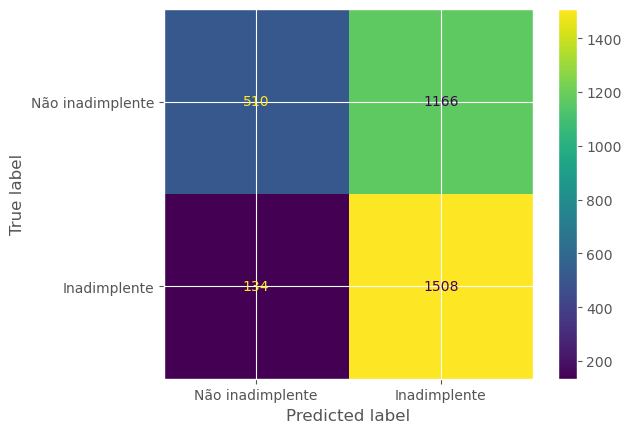

In [124]:
ConfusionMatrixDisplay.from_estimator(final_model,
                                     X_test_pp1,
                                     y_test,
                                     display_labels=['Não inadimplente','Inadimplente']);

## 10. Impacto da implementação do modelo

## 11. Considerações finais